**Semantic Book Recommendation System**
=======================================

**Project Overview**
--------------------

The Semantic Book Recommendation System is designed to provide personalized book recommendations based on the semantic understanding of book descriptions and user preferences. Leveraging text embeddings and Large Language Models (LLMs), the system transforms textual data into high-dimensional vectors to compute similarities between books. This approach ensures recommendations are contextually relevant, going beyond simple keyword matching to understand deeper meanings and relationships in the text.

* * * * *

**Project Description**
-----------------------

The goal of this project is to build a recommendation system that:

1.  **Processes Book Metadata**: Uses book titles, descriptions, authors, and categories to generate embeddings.

2.  **Computes Semantic Similarity**: Employs LLMs to derive meaning from embeddings and measure similarity between books.

3.  **Recommends Books**: Suggests books based on user input (e.g., a book title or description) by finding the most semantically similar books in the dataset.

The system is built using Python, with libraries like `transformers` for embeddings, `langchain` for LLM integration, and `gradio` for a user-friendly interface.

* * * * *

**Workflow**
------------

1.  **Data Collection and Cleaning**:

    -   Load a dataset of books with metadata (e.g., title, description, categories).

    -   Clean and preprocess text data (remove duplicates, handle missing values, standardize formats).

2.  **Text Embedding Generation**:

    -   Use pre-trained models (e.g., BERT, Sentence-BERT) to convert book descriptions into vector embeddings.

    -   Store embeddings for efficient similarity calculations.

3.  **Semantic Similarity Calculation**:

    -   Compute cosine similarity or other distance metrics between embeddings to measure book similarity.

    -   Rank books based on similarity scores.

4.  **Recommendation Generation**:

    -   Accept user input (e.g., a book title or description).

    -   Generate embeddings for the input and compare with stored book embeddings.

    -   Return the top-N most similar books as recommendations.

5.  **User Interface**:

    -   Deploy a Gradio-based interface for users to input preferences and view recommendations.

* * * * *

**Technologies Used**
---------------------

1.  **Python**: Primary programming language for data processing and model implementation.

2.  **Pandas & NumPy**: For data manipulation and numerical operations.

3.  **Transformers (Hugging Face)**: For generating text embeddings using pre-trained models.

4.  **LangChain**: To integrate LLMs for semantic understanding and retrieval-augmented tasks.

5.  **Gradio**: For building an interactive web interface for users.

6.  **Scikit-learn**: For similarity metrics (e.g., cosine similarity).

7.  **ChromaDB/FAISS**: For efficient storage and retrieval of embeddings.

8.  **Matplotlib/Seaborn**: For data visualization (optional, for exploratory analysis).

* * * * *

**Key Definitions**
-------------------

1.  **Text Embeddings**:

    -   Numerical representations of text that capture semantic meaning. Generated using models like BERT, they allow mathematical comparison of textual similarity.

2.  **Large Language Models (LLMs)**:

    -   Models like BERT or GPT trained on vast text corpora to understand and generate human-like text. Used here to derive semantic meaning from book descriptions.

3.  **Semantic Similarity**:

    -   A measure of how closely two pieces of text align in meaning, calculated using embeddings (e.g., cosine similarity).

4.  **Gradio**:

    -   A Python library for creating quick, customizable UIs for machine learning models.

5.  **LangChain**:

    -   A framework for integrating LLMs into applications, enabling advanced retrieval and generation tasks.

6.  **ChromaDB**:

    -   A vector database optimized for storing and querying embeddings efficiently.

* * * * *

**Conclusion**
--------------

This project demonstrates how semantic understanding can enhance recommendation systems by moving beyond surface-level features. By combining embeddings, LLMs, and efficient retrieval methods, the system provides meaningful book suggestions tailored to user preferences. Future enhancements could include user feedback loops, hybrid recommendation strategies (collaborative filtering + semantic), and multilingual support.

In [3]:
import pandas as pd 
import numpy as np
import re 
import gradio as gr
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# **Semantic book Recommender**

## 1-**Data cleaning**

### **Data investigation**

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/7k-books-with-metadata


In [5]:
df = pd.read_csv(f'{path}/books.csv')

In [6]:
df.head(5)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


<Axes: >

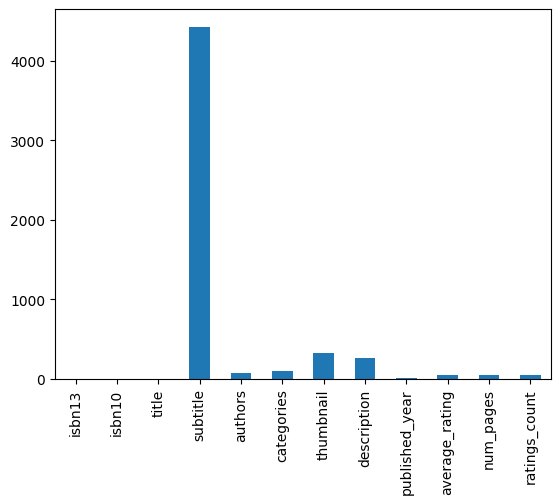

In [7]:
df.isna().sum().plot(kind='bar')

In [8]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

In [9]:
len(df['categories'].unique())

568

<Axes: xlabel='categories'>

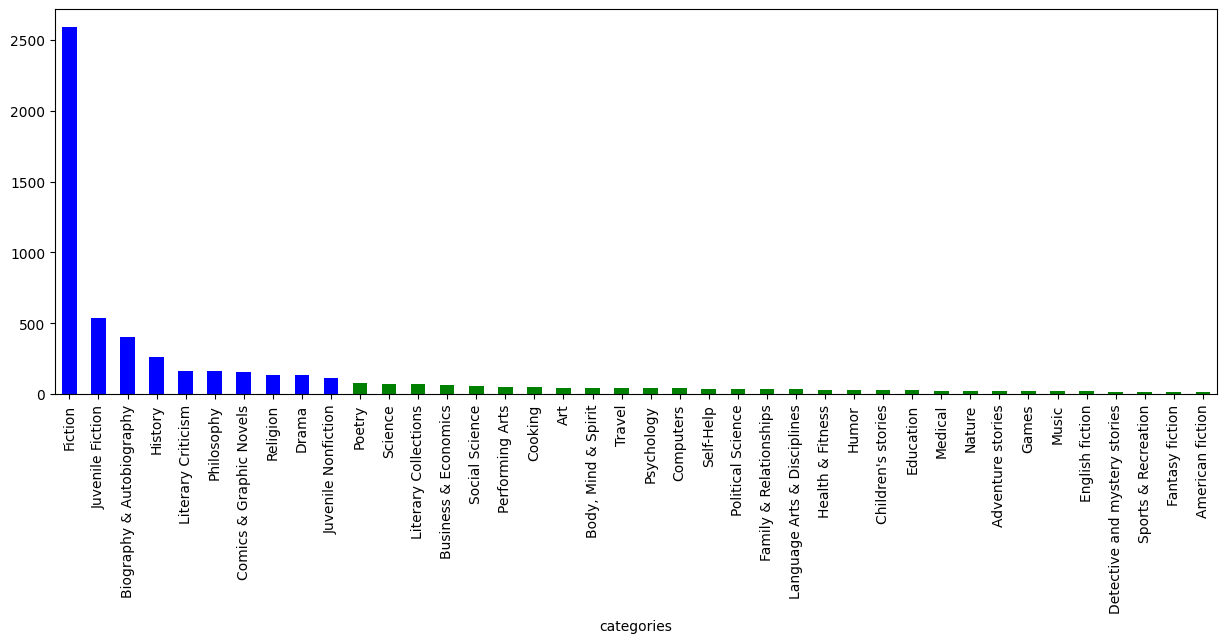

In [10]:
color = ['blue' if x > 100 else 'green' for x in df['categories'].value_counts()[:40] ]
plt.figure(figsize=(15,5))
df['categories'].value_counts()[:40].plot(kind='bar',color=color)

(array([1987.5, 1990. , 1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. ,
        2007.5, 2010. ]),
 [Text(1987.5, 0, '1987.5'),
  Text(1990.0, 0, '1990.0'),
  Text(1992.5, 0, '1992.5'),
  Text(1995.0, 0, '1995.0'),
  Text(1997.5, 0, '1997.5'),
  Text(2000.0, 0, '2000.0'),
  Text(2002.5, 0, '2002.5'),
  Text(2005.0, 0, '2005.0'),
  Text(2007.5, 0, '2007.5'),
  Text(2010.0, 0, '2010.0')])

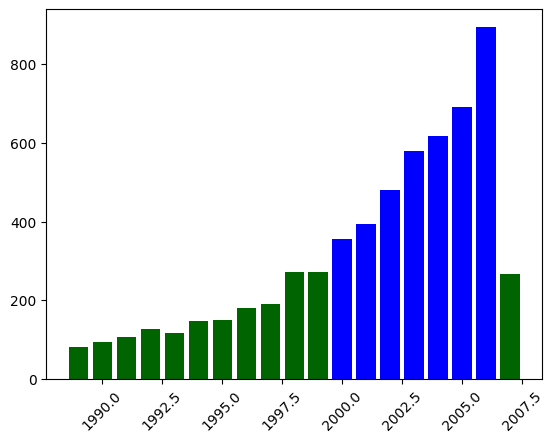

In [11]:
books_year_publishing = df['published_year'].value_counts()
books_year_publishing = books_year_publishing[books_year_publishing >= books_year_publishing.mean()]
c = ['blue' if x >= 300 else 'darkgreen' for x in books_year_publishing]
plt.bar(books_year_publishing.index,books_year_publishing.values,color=c)
plt.xticks(rotation=45)

Text(50.58159722222221, 0.5, 'Missing values')

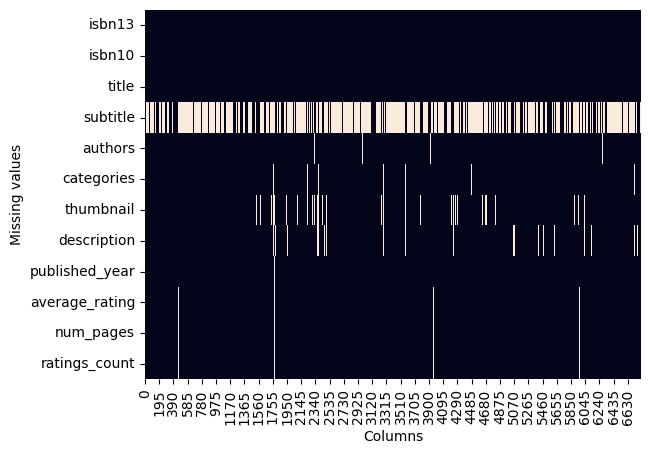

In [12]:
ax = plt.axes()

sns.heatmap(df.isna().transpose(),ax=ax,cbar=False)
plt.xlabel('Columns')
plt.ylabel('Missing values')

#### The heatmap reveals a pattern in missing data, so further investigation is needed to understand the cause and prevent bias during data cleaning.

In [13]:

df["missing_description"] = np.where(df['description'].isna(),1,0)
df['book_age'] = 2025-df['published_year']

<Axes: >

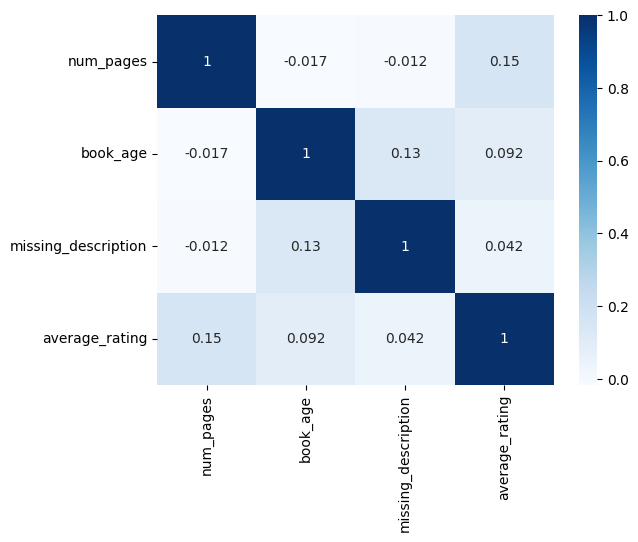

In [14]:
col_of_interest = ['num_pages',"book_age","missing_description","average_rating"]
sns.heatmap(df[col_of_interest].corr(method='spearman'),cmap='Blues',annot=True)

<Axes: >

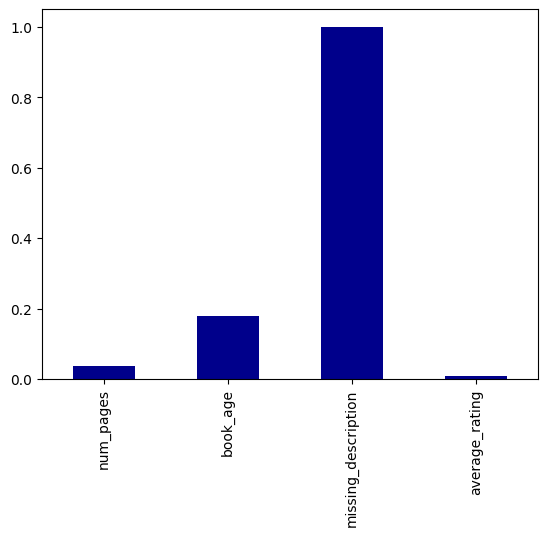

In [15]:
corr = df[col_of_interest].corrwith(df['missing_description'])
corr.plot(kind='bar',color='darkblue')

#### The correlation analysis reveals a negligible correlation between missing descriptions, number of pages, rating, and book age. This suggests our dataset is unlikely to be biased and is representative so we will drop the rows with na value in avg ratings and description and publicashed_year.

In [16]:
col_of_interest

['num_pages', 'book_age', 'missing_description', 'average_rating']

In [17]:
df = df[~(df["num_pages"].isna())&
                (~df["average_rating"].isna())&
                (~df["description"].isna())&
                (~df["published_year"].isna())]


In [18]:
df.head(3)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,book_age
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0


In [19]:
df['words_in_description'] = df['description'].str.split().str.len()

<Axes: xlabel='words_in_description', ylabel='Count'>

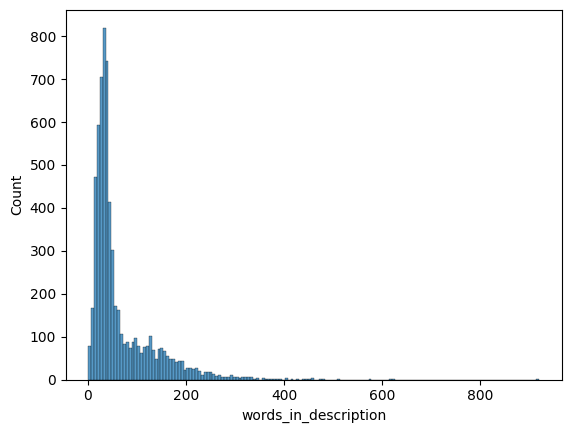

In [20]:
sns.histplot(df['words_in_description'])

In [21]:
df['description'][df['words_in_description'].between(1,4)]

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

In [22]:
df['description'][df['words_in_description'].between(5,14)]

2       Volume Two of Stephen Donaldson's acclaimed se...
38      Koko is Peter Straub's foray into the psycholo...
70      A matter of life and death - and the Throne of...
77                         Nonsense rhyming story. 4 yrs+
84      A study guide for the novel There's a Boy in t...
                              ...                        
6715    The first comprehensive guide to addressing Na...
6726       Presents two complete novels from Henry James.
6757                          Audio Book- unabriged on CD
6776    Raymond Chandler meets The Exorcist. Classic n...
6795    Book Of Five Rings is a Kodansha International...
Name: description, Length: 308, dtype: object

In [23]:
df['description'][df['words_in_description'].between(15,24)]

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 947, dtype: object

In [24]:
df['description'][df['words_in_description'].between(25,34)]

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1229, dtype: object

In [25]:
len(df)-len(df['description'][df['words_in_description'].between(0,24)])

5197

In [26]:
df = df[df['words_in_description'] >= 25]
len(df)

5197

In [27]:
df['title and subtitle'] = np.where(
    df['subtitle'].isna(), 
    df['title'], 
    df[['title', 'subtitle']].astype(str).agg(": ".join, axis=1))


In [28]:
df['tagged_desc'] = df[["isbn13","description"]].astype(str).agg(" ".join,axis=1)

In [29]:
df.columns


Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count', 'missing_description', 'book_age',
       'words_in_description', 'title and subtitle', 'tagged_desc'],
      dtype='object')

In [30]:
(
    df.drop(['subtitle','missing_description','book_age','words_in_description'],axis=1).to_csv("df_cleaned.csv",index=False)
)

## 2-Data processing :Vector search
### 2-1 

In [31]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [32]:
df = pd.read_csv("/kaggle/working/df_cleaned.csv")

In [33]:
df.head(5)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title and subtitle,tagged_desc
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


In [34]:
df['tagged_desc'].to_csv('tagg_desc.text',sep='\n',
                        index=False,
                        header = False)

In [35]:
raw_doc = TextLoader('tagg_desc.text').load()
text_splitter = CharacterTextSplitter(chunk_size=0,chunk_overlap=0,separator="\n")
documents = text_splitter.split_documents(raw_doc)

In [36]:
documents[0]

Document(metadata={'source': 'tagg_desc.text'}, page_content='9780002005883 A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is 

## 3- creating the semantic recommendation system 

In [37]:
from langchain.embeddings import HuggingFaceEmbeddings

# Load a local embedding model
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

db_books = Chroma.from_documents(
    documents,
    embedding=embedding
)

<ipython-input-37-e7db34755f4a>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
query = "a book about war in rome"
docs = db_books.similarity_search(query,k=10)
docs


[Document(id='a1d92be4-4061-46f0-88cd-c68dc29ff4ef', metadata={'source': 'tagg_desc.text'}, page_content="9780192833006 Cornelius Tacitus, Rome's greatest historian, was inspired to take up his pen when the assassination of Domitian ended `fifteen years of enforced silence'. Agricola is the biography of his late father-in-law and an account of Roman Britain. Germania gives insight into Rome's most dangerous enemies, the Germans, and is the only surviving specimen from the ancient world of an ethnographic study. Each in its way has had immense influence on our perception of Rome and the northern `barbarians' and the edition reflects recent research in Roman-British and Roman-German history. - ;`Long may the barbarians continue, I pray, if not to love us, at least to hate one another.' Cornelius Tacitus, Rome's greatest historian and the last great writer of classical Latin prose, produced his first two books in AD 98. He was inspired to take up his pen when the assassination of Domitian

In [39]:
text = 'to anthropologists. It is 9780786808069 a richly informative text for advance'

In [40]:
import re
text = 'to anthropologists. It is 9780786808069 a richly informative text for advance'
patern = r'([0-9]{13})'
re.findall(patern,text)

['9780786808069']

In [41]:
idx = re.findall(patern,str(docs))

In [42]:
def get_recommendation(query):
    docs = db_books.similarity_search(query,k=10)
    
    idx = re.findall(patern,str(docs))
    recommended_books = []
    for id in idx :
        title = df[df['isbn13']==int(id)]['title']
        recommended_books.append(title)
    print(recommended_books)

In [43]:
get_recommendation('Psychology')

[799    The Blank Slate
Name: title, dtype: object, 4898    The Nature of Play
Name: title, dtype: object, 3145    The Denial of Death
Name: title, dtype: object, 562    Love's Executioner
Name: title, dtype: object, 280    DREAM & THE UNDERWOR
Name: title, dtype: object, 2476    Extraordinary Popular Delusions and the Madnes...
Name: title, dtype: object, 1569    Feel the Fear-- and Do it Anyway
Name: title, dtype: object, 3195    Phantoms in the Brain
Name: title, dtype: object, 4385    Learned Optimism
Name: title, dtype: object, 1933    The Body Remembers: The Psychophysiology of Tr...
Name: title, dtype: object]


In [44]:
docs[0].page_content.split()[0]

'9780192833006'

In [45]:
def retrieve_semantic_recommendations(query, top_k=10):
    recs = db_books.similarity_search(query, k=50)
    books_list = []
    
    for doc in recs:  # Fixed iteration through documents
        # Extract first word/number from page content as ISBN candidate
        isbn_candidate = doc.page_content.strip('"').split()[0]
        
        try:
            # Convert to int if it's a valid number
            books_list.append(int(isbn_candidate))
        except ValueError:
            # Skip if not a valid number
            continue
    
    # Filter dataframe and return top_k results
    return df[df["isbn13"].isin(books_list)][['title','authors',"categories"]].head(top_k)

In [46]:
retrieve_semantic_recommendations('book about war')

,title,authors,categories
66,If I Die in a Combat Zone,Tim O'Brien,"Vietnam War, 1961-1975"
461,The Great World,David Malouf,Australia
524,All Quiet on the Western Front,Erich Maria Remarque,"World War, 1914-1918"
541,A Farewell to Arms,Ernest Hemingway,War
572,We Were the Rats,Lawson Glassop,"Tobruk, Battles of, 1941-1942"
749,The Good Soldier Svejk,Jaroslav Hašek,Czechoslovakia
756,Orwell in Spain,George Orwell,Fiction
796,When the Elephants Dance,Tess Uriza Holthe,Fiction
955,La Débâcle,Emile Zola;Elinor Dorday;Robert Lethbridge,Fiction
999,Ride of the Second Horseman,Robert L. O'Connell,History


## 4- Description classification

In [47]:
categories = df['categories'].value_counts().reset_index().query("count >= 50")['categories']

In [48]:
categories.tolist()

['Fiction',
 'Juvenile Fiction',
 'Biography & Autobiography',
 'History',
 'Literary Criticism',
 'Religion',
 'Philosophy',
 'Comics & Graphic Novels',
 'Drama',
 'Juvenile Nonfiction',
 'Science',
 'Poetry',
 'Literary Collections']

In [49]:
categ_mapping = {'Fiction':"fiction",
 'Juvenile Fiction':"children fiction",
 'Biography & Autobiography':"Nonfiction",
 'History':"Nonfiction",
 'Literary Criticism':"Nonfiction",
 'Religion':"Nonfiction",
 'Philosophy':"Nonfiction",
 'Comics & Graphic Novels':"fiction",
 'Drama':"fiction",
 'Juvenile Nonfiction':"children Nonfiction",
 'Science':"Nonfiction",
 'Poetry':"fiction"}

In [50]:
df['simple_categ'] = df['categories'].map(categ_mapping)

In [51]:
df['simple_categ']

0          fiction
1              NaN
2          fiction
3              NaN
4              NaN
           ...    
5192           NaN
5193           NaN
5194           NaN
5195    Nonfiction
5196    Nonfiction
Name: simple_categ, Length: 5197, dtype: object

In [52]:
len(df[~df['simple_categ'].isna()]),len(df[df['simple_categ'].isna()])

(3743, 1454)

In [53]:
from transformers import pipeline

In [54]:
categories = ['fiction','Nonfiction']
classifier = pipeline("zero-shot-classification",model='facebook/bart-large-mnli',device=0)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [55]:
def generate_prediction(seq,categories):
    predictions = classifier(seq,categories)
    max_index = np.argmax(predictions['scores'])
    max_label = predictions['labels'][max_index]
    return max_label

In [56]:
generate_prediction('it a book about the legend of assassins creed',categories)

'fiction'

In [57]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'authors', 'categories', 'thumbnail',
       'description', 'published_year', 'average_rating', 'num_pages',
       'ratings_count', 'title and subtitle', 'tagged_desc', 'simple_categ'],
      dtype='object')

In [58]:
def generate_prediction(seq,categories):
    predictions = classifier(seq,categories)
    max_index = np.argmax(predictions['scores'])
    max_label = predictions['labels'][max_index]
    return max_label
    
from tqdm.auto import tqdm 
actual_cat = []
predicted_cat = []

for i in tqdm(range(0,300)):
    seq = df.loc[df['simple_categ']=='fiction','description'].reset_index(drop=True)[i]
    predicted_cat.append(generate_prediction(seq,categories))
    actual_cat += ["fiction"]
for i in tqdm(range(0,300)):
    seq = df.loc[df['simple_categ']=='Nonfiction','description'].reset_index(drop=True)[i]
    predicted_cat.append(generate_prediction(seq,categories))
    actual_cat += ["Nonfiction"]   
eval_data = pd.DataFrame({'prediction':predicted_cat,'actual_cat':actual_cat})



  0%|          | 0/300 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/300 [00:00<?, ?it/s]

<Axes: xlabel='evaluation', ylabel='count'>

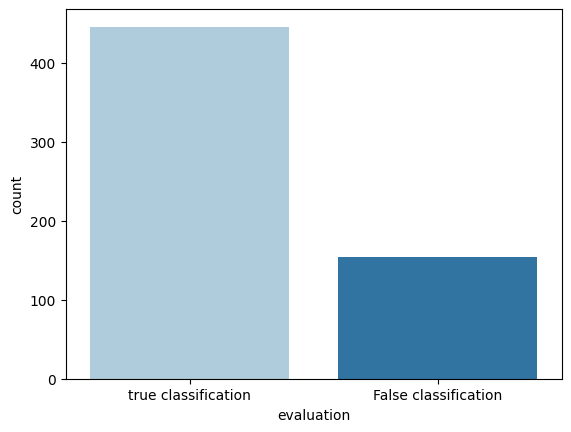

In [59]:
eval_data['evaluation'] = ["true classification" if eval_data.iloc[id,1]== eval_data.iloc[id,0] else "False classification" for id in range(len(eval_data))]
sns.countplot(x=eval_data['evaluation'],palette='Paired')


In [60]:
isbn = []
predicted_cats = []
missing_cats = df.loc[df['simple_categ'].isna(),['isbn13','description']].reset_index(drop=True)

In [61]:
for i in tqdm(range(0,len(missing_cats))):
    seq = missing_cats['description'][i]
    predicted_cats += [generate_prediction(seq,categories)]
    isbn +=  [missing_cats['isbn13'][i]]

  0%|          | 0/1454 [00:00<?, ?it/s]

In [62]:
miss_cats = pd.DataFrame({'isbn13':isbn,'predicted_categ':predicted_cats})
miss_cats.head()

,isbn13,predicted_categ
0,9780002261982,fiction
1,9780006280897,Nonfiction
2,9780006280934,Nonfiction
3,9780006380832,Nonfiction
4,9780006470229,fiction


In [63]:
len(df)

5197

In [64]:
df = pd.merge(df,miss_cats, on='isbn13',how='left')
len(df)

5197

In [65]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'authors', 'categories', 'thumbnail',
       'description', 'published_year', 'average_rating', 'num_pages',
       'ratings_count', 'title and subtitle', 'tagged_desc', 'simple_categ',
       'predicted_categ'],
      dtype='object')

In [66]:
df["simple_categ_x"] = np.where(df["simple_categ"].isna(),df["predicted_categ"],df["simple_categ"])

In [67]:
df.isna().sum()

isbn13                   0
isbn10                   0
title                    0
authors                 32
categories              30
thumbnail              166
description              0
published_year           0
average_rating           0
num_pages                0
ratings_count            0
title and subtitle       0
tagged_desc              0
simple_categ          1454
predicted_categ       3743
simple_categ_x           0
dtype: int64

In [68]:
df.drop(['predicted_categ','simple_categ'],axis=1,inplace=True)

In [69]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'authors', 'categories', 'thumbnail',
       'description', 'published_year', 'average_rating', 'num_pages',
       'ratings_count', 'title and subtitle', 'tagged_desc', 'simple_categ_x'],
      dtype='object')

## 5- gradio web app 

### 5-1 recommendation engine

In [70]:
df

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title and subtitle,tagged_desc,simple_categ_x
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,Mistaken Identity,9788172235222 On A Train Journey Home To North...,Nonfiction
5193,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction
5194,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,fiction
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction


In [71]:
def retrieve_semantic_recommendation(query:str,category:str=None,inital_top_k=50,final_top_k=16)->pd.DataFrame:
    recs = db_books.similarity_search(query,inital_top_k)
    books_list = [int(rec.page_content.strip('"').split()[0]) for rec in recs]
    books_recs = df[df['isbn13'].isin (books_list)].head(final_top_k)
    
    if category != 'All':
        books_recs = books_recs[books_recs['simple_categ_x']==category].head(final_top_k)
    else:
        books_recs 
    return books_recs



In [72]:
retrieve_semantic_recommendation('economie',"All")

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title and subtitle,tagged_desc,simple_categ_x
128,9780060521998,0060521996,The Innovator's Dilemma,Clayton M. Christensen,Business & Economics,http://books.google.com/books/content?id=qZxlD...,"In this revolutionary bestseller, Harvard prof...",2003.0,3.99,286.0,28568.0,The Innovator's Dilemma: The Revolutionary Boo...,9780060521998 In this revolutionary bestseller...,Nonfiction
483,9780099428633,0099428636,How to Travel with a Salmon and Other Essays,Umberto Eco,Essays,http://books.google.com/books/content?id=-SLft...,This witty and irreverent collection of essays...,2001.0,3.85,229.0,106.0,How to Travel with a Salmon and Other Essays,9780099428633 This witty and irreverent collec...,Nonfiction
626,9780140285970,0140285970,Shadows and Wind,Robert Templer,History,http://books.google.com/books/content?id=CFiaQ...,"Examines the problems facing modern Vietnam, a...",1998.0,3.48,400.0,101.0,Shadows and Wind: A View of Modern Vietnam,9780140285970 Examines the problems facing mod...,Nonfiction
688,9780140447606,0140447601,Democracy in America,Alexis Tocqueville;Gerald Bevan;Isaac Kramnick,History,http://books.google.com/books/content?id=Potlk...,"A study of America's national government, egal...",2003.0,4.02,992.0,18286.0,Democracy in America: And Two Essays on America,9780140447606 A study of America's national go...,Nonfiction
844,9780143036081,0143036084,The United States of Europe,T. R. Reid,History,http://books.google.com/books/content?id=Yra-G...,Now comprising 25 nations and 450 million citi...,2005.0,3.62,320.0,681.0,The United States of Europe: The New Superpowe...,9780143036081 Now comprising 25 nations and 45...,Nonfiction
865,9780143038825,0143038826,The White Man's Burden,William Easterly,Business & Economics,http://books.google.com/books/content?id=8SayN...,Argues that western foreign aid efforts have d...,2006.0,3.83,436.0,4317.0,The White Man's Burden: Why the West's Efforts...,9780143038825 Argues that western foreign aid ...,Nonfiction
877,9780151010264,0151010269,Animal Farm and 1984,George Orwell,Fiction,http://books.google.com/books/content?id=h1KIm...,George Orwell's classic satire on totalitarian...,2003.0,4.28,400.0,140015.0,Animal Farm and 1984,9780151010264 George Orwell's classic satire o...,fiction
1025,9780199296095,019929609X,An Introduction to Political Philosophy,Jonathan Wolff,Philosophy,http://books.google.com/books/content?id=FVOcA...,The revised edition of this highly successful ...,2006.0,4.11,215.0,703.0,An Introduction to Political Philosophy,9780199296095 The revised edition of this high...,Nonfiction
1055,9780226675763,0226675769,"Antitrust Law, Second Edition",Richard A. Posner,Law,http://books.google.com/books/content?id=wvkym...,When it was first published a quarter of a cen...,2001.0,4.00,304.0,33.0,"Antitrust Law, Second Edition",9780226675763 When it was first published a qu...,Nonfiction
1097,9780262611336,0262611333,Pop Internationalism,Paul R. Krugman,Business & Economics,http://books.google.com/books/content?id=17Yrn...,"""Pop internationalists""--people who speak impr...",1997.0,3.67,221.0,307.0,Pop Internationalism,"9780262611336 ""Pop internationalists""--people ...",Nonfiction


### 5-1 the gradio display function

In [73]:
df['large_thumbnail'] = df['thumbnail'] + "&fife=w800"

In [80]:
result_1 = []
famous_books = df.sort_values(by="average_rating", ascending=False).head(8*4)[["title", "large_thumbnail"]]
for _, row in famous_books.iterrows():
    title = row['title']
    result_1.append((row['large_thumbnail'], title))

def recommend_books(query: str, category: str):
    recommendations = retrieve_semantic_recommendation(query, category)
    result = []
    
    for _, row in recommendations.iterrows():
        desc = row['description']
        short_desc_split = desc.split()
        short_desc = ' '.join(short_desc_split[:30]) + "...." 
        
        authors_split = row['authors'].split(';')
        authors = ' - '.join(authors_split)
        
        caption = f"{row['title']} by {authors} : {short_desc} "
        result.append((row["large_thumbnail"], caption))
    return result

categories = ["All"] + sorted(df['simple_categ_x'].unique())

with gr.Blocks(theme='hmb/amethyst') as dashboard:
    gr.Markdown('# 📚 **Semantic Book Recommender**')
    
    with gr.Row():
        user_query = gr.Textbox(label='Please enter the description of the Book :', placeholder="e.g A book about power and fear")
        category_drop_down = gr.Dropdown(label="Select a category:", choices=categories, value='All')
        submit_button = gr.Button('Search')
    
    gr.Markdown('## Recommendation') 
    output = gr.Gallery(label='Recommended books', columns=8, rows=2, value=result_1)
    
    submit_button.click(fn=recommend_books, inputs=[user_query, category_drop_down], outputs=[output])

dashboard.launch()


theme_schema%400.0.2.json:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

* Running on local URL:  http://127.0.0.1:7862
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://d7e29427ad16c552ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
